Part II:
- loads the feature files for each snapshot from the features_csv folder
- perform a clustering algorithm on each snapshot and plot the results

In [1]:
import pandas as pd
import os

# Directory where the CSV files are stored
input_directory = "features_csv"

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(input_directory) if f.endswith(".csv")]

# Sort the CSV files based on the numeric part of the filename: 100ps, 200ps, .............., 2300ps
csv_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

# Initialize an empty dictionary to store the DataFrames
df_dict = {}

# Loop through the sorted CSV files and load them into DataFrames
for csv_file in csv_files:
    # Extract the numeric part of the filename (e.g., "100" from "100.csv")
    numeric_part = os.path.splitext(csv_file)[0]
#     numeric_part = filename_without_extension
    
    # Load the CSV file into a DataFrame and use the numeric part as the key
    df_dict[numeric_part] = pd.read_csv(os.path.join(input_directory, csv_file))



In [2]:
df_dict

{'100':           ID         x         y          z        Q6  Nc_6  dist_from_c  \
 0      39897 -15.73950  -1.96347  -2.739140  0.275710     8    16.096272   
 1      39898 -15.47140  -3.91111   2.078920  0.335506     1    16.092946   
 2      39899 -15.33970  -0.70166  -0.203704  0.396995     5    15.357090   
 3      39900 -16.70370  -3.27492  -0.332060  0.336005    15    17.024951   
 4      39901 -12.85300   4.47663  -6.688980  0.354365    15    15.165167   
 ...      ...       ...       ...        ...       ...   ...          ...   
 59851  99748 -46.22590   6.62380  -4.489330  0.310877     8    46.913352   
 59852  99749  41.97220  51.67530  41.936900  0.259841     2    78.681038   
 59853  99750  -1.12744 -16.02210 -31.473700  0.253096     1    35.335147   
 59854  99751  31.63570 -51.05800   9.377510  0.286128     2    60.792060   
 59855  99752  46.65490   1.82923   7.790350  0.292243     1    47.336195   
 
            disp      d_5NN  N_N  
 0      0.930601   3.369484    9

- df_dict is a dictionary with keys in increasing order of snapshot time from 100-2700
- To confirm the order you may run
   - df_dict.keys()
   
__Let us work out the clustering algorithm now__

__Perform clustering for all the snaphots and write a xyz file for the crystal like atoms__

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pyprind
import numpy as np

# Ensure your dictionary df_dict is defined
# df_dict = {identifier: df, ...}

prog_bar = pyprind.ProgBar(len(df_dict.keys()))

# Initialize lists to store results
n_atoms_per_cluster = []
avg_disp_per_cluster = []
avg_Nc_per_cluster = []
mean_Q6_snap = []
mean_Nc_snap = []
mean_disp_snap = []
cc_I = []
cc_II = []
ct_Nc_gt_10 = []

# Open a single .xyz file in write mode
output_filename = "combined_output.xyz"
box_dimensions = "104.0 104.0 104.0"
with open(output_filename, 'w') as xyz_file:

    # Iterate through each DataFrame in the dictionary
    for identifier, df in df_dict.items():
        X = df
        X_mat = X[['Q6', 'Nc_6', 'disp', 'N_N']].values
        
        # Collect snapshot statistics
        ct_Nc_gt_10.append(len(X_mat[X_mat[:, 3] > 10]))
        mean_Q6_snap.append(np.mean(X_mat[:, 0]))
        mean_Nc_snap.append(np.mean(X_mat[:, 1]))
        mean_disp_snap.append(np.mean(X_mat[:, 2]))
        
        # Standardize the features
        sc = StandardScaler()
        X_std = sc.fit_transform(X_mat)
        
        # Perform KMeans clustering
        km = KMeans(n_clusters=2, init='k-means++', n_init=100, max_iter=100000, tol=1e-10, random_state=0)
        y_km = km.fit_predict(X_std)    

        cc_I.append(km.cluster_centers_[0, :])
        cc_II.append(km.cluster_centers_[1, :])  
        
        # Calculate the mean value of the 2nd column for each cluster
        avg_2nd_col = [np.mean(X_mat[y_km == i, 1]) for i in range(2)]

        # Determine the cluster with the larger mean value of the 2nd column as label 1
        larger_avg_c = np.argmax(avg_2nd_col)
        c_labels = [1 if i == larger_avg_c else 0 for i in range(2)]

        # Map cluster labels to the original KMeans labels
        final_labels = [c_labels[label] for label in y_km]
        df['Cluster_Labels'] = final_labels

        # Append the number of atoms per cluster
        n_atoms_per_cluster.append([final_labels.count(1), final_labels.count(0)])

        # Filter data based on cluster labels
        filtered_df1 = df[df['Cluster_Labels'] == 1]

        # Append average displacement per cluster
        avg_disp_per_cluster.append([filtered_df1['disp'].mean(), filtered_df1['disp'].mean()])
        avg_Nc_per_cluster.append([filtered_df1['Nc_6'].mean(), filtered_df1['Nc_6'].mean()])

        # Write to the .xyz file
        num_atoms = len(filtered_df1)
        # Write number of atoms
        xyz_file.write(f"{num_atoms}\n")
        # Write the box dimensions
        xyz_file.write(f"{box_dimensions}\n")
        # Write coordinates
        for _, row in filtered_df1.iterrows():
            xyz_file.write(f"{row['x']} {row['y']} {row['z']}\n")

        # Update the progress bar
        prog_bar.update()


0% [###########################] 100% | ETA: 00:00:00
Total time elapsed: 00:04:10


In [7]:
avg_Nc_per_cluster

[[11.8125, 11.8125],
 [11.668371073776479, 11.668371073776479],
 [11.98477829252151, 11.98477829252151],
 [12.764019988895058, 12.764019988895058],
 [12.017514124293786, 12.017514124293786],
 [11.678270042194093, 11.678270042194093],
 [11.603716725263686, 11.603716725263686],
 [11.39759572573464, 11.39759572573464],
 [11.798739306618641, 11.798739306618641],
 [11.802452316076295, 11.802452316076295],
 [12.23580365736285, 12.23580365736285],
 [12.524434515498465, 12.524434515498465],
 [12.236015701668302, 12.236015701668302],
 [12.513157894736842, 12.513157894736842],
 [12.449564375605034, 12.449564375605034],
 [12.36781206171108, 12.36781206171108],
 [11.976327575175944, 11.976327575175944],
 [12.199399227578315, 12.199399227578315],
 [12.440743998994597, 12.440743998994597],
 [12.280870611396697, 12.280870611396697],
 [12.59915195740065, 12.59915195740065],
 [12.267363571934798, 12.267363571934798],
 [12.292176039119804, 12.292176039119804],
 [12.479676542149706, 12.479676542149706],


In [8]:
n_atoms_per_cluster

[[1120, 58736],
 [1369, 58487],
 [1511, 58345],
 [1801, 58055],
 [1770, 58086],
 [1896, 57960],
 [1991, 57865],
 [2246, 57610],
 [2221, 57635],
 [2936, 56920],
 [3117, 56739],
 [3581, 56275],
 [4076, 55780],
 [4712, 55144],
 [5165, 54691],
 [5704, 54152],
 [6252, 53604],
 [6991, 52865],
 [7957, 51899],
 [9143, 50713],
 [10141, 49715],
 [11288, 48568],
 [12270, 47586],
 [13974, 45882],
 [15983, 43873],
 [18067, 41789],
 [20273, 39583]]

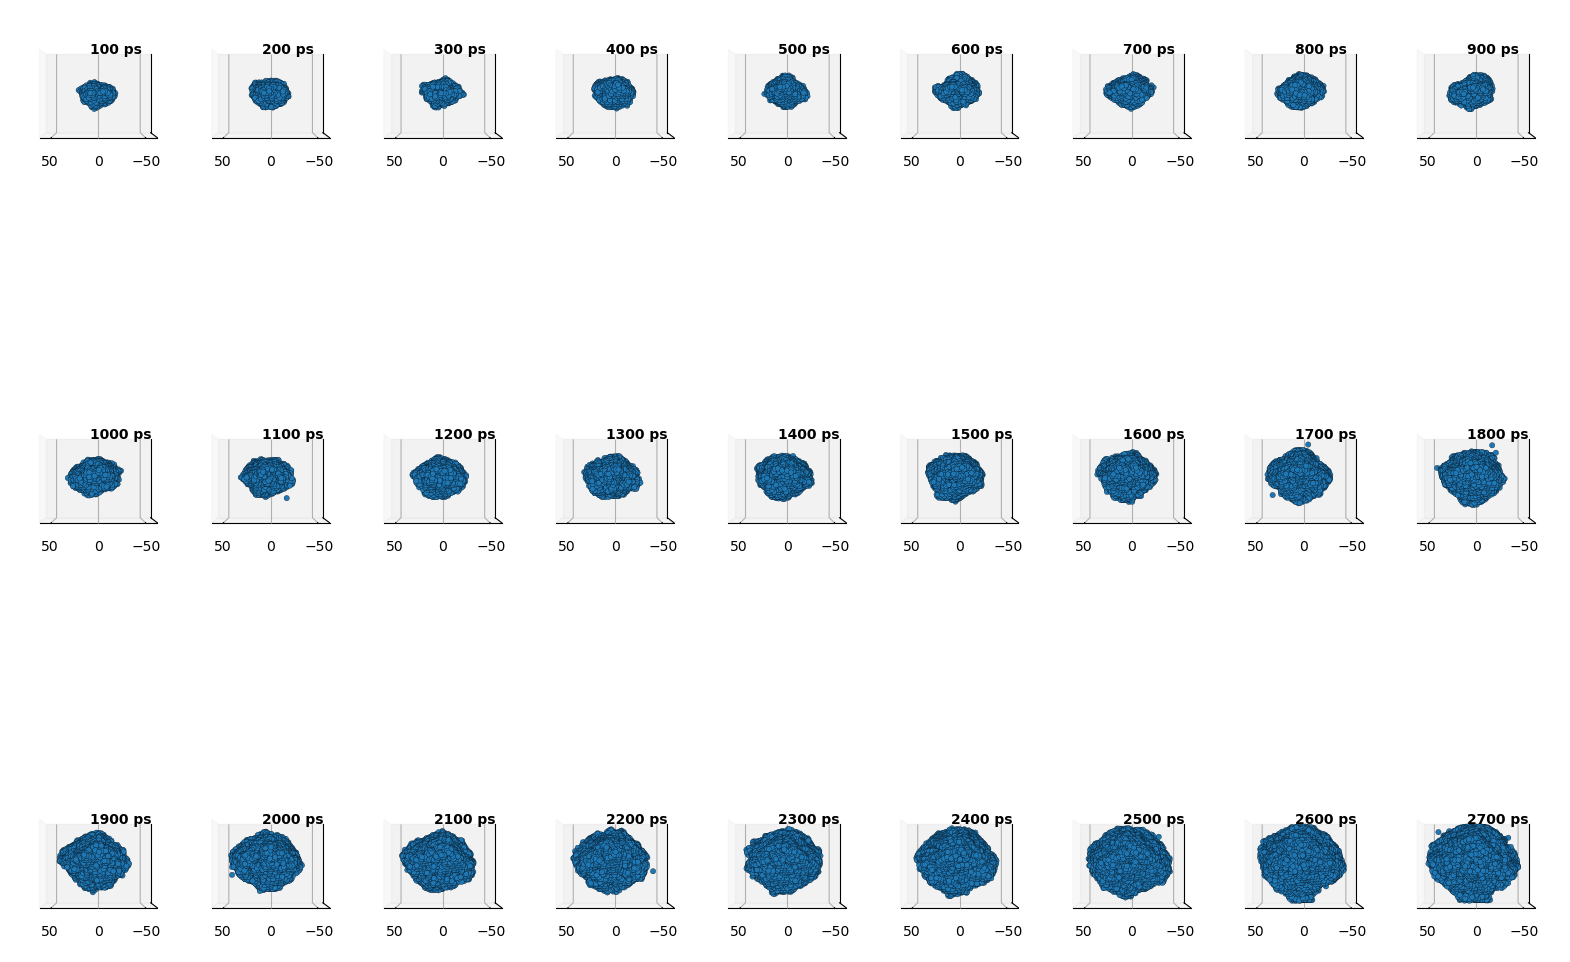

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plots


fig = plt.figure(figsize=(20,15))
rows = 3
cols = int(len(df_dict)/rows)
gs = gridspec.GridSpec(rows, cols, wspace=0.0005, hspace=0.0005)

# for ind in range(len(df_dict.keys())):
ind = 0 
for identifier, df in df_dict.items():
    X = df
    rx,ry,rz = np.asarray(X['x']), np.asarray(X['y']), np.asarray(X['z'])
    indices = []
    for ct_ in range(len(X)):
        if X['Cluster_Labels'].iloc[ct_] == 1:
            indices.append(ct_)
    selected_rows = X.iloc[indices]
    
    
#     if ind== 19:
#         selected_rows[['x','y','z']].to_csv('pred_crystals_2000ps.xyz', sep='\t', header=None, index=None)

#         print(selected_rows[['Q6','Nc_6','disp','N_N']])

    x_slice, y_slice, z_slice = [rx[i] for i in indices], [ry[i] for i in indices],[rz[i] for i in indices]
    ax = fig.add_subplot(gs[ind//cols, ind%cols], projection='3d')
    ax.scatter(x_slice, y_slice, z_slice, s=15.0, linewidth=0.2, alpha=1.0,edgecolor='k');
    
    ax.view_init(elev=0, azim=90, roll=0)
    ax.text(10.0, 0.0, 60.0, f'{(ind+1)*100} ps', color='k', fontsize=10, fontweight='bold')
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.set_zlim(-60,60)
#     ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ind += 1
plt.savefig("crystal_Ox_cluster.png",dpi=400)
# plt.tight_layout()
plt.show()


In [11]:
NAT = len(df_dict['100'])

In [12]:
len(avg_Nc_per_cluster)

27

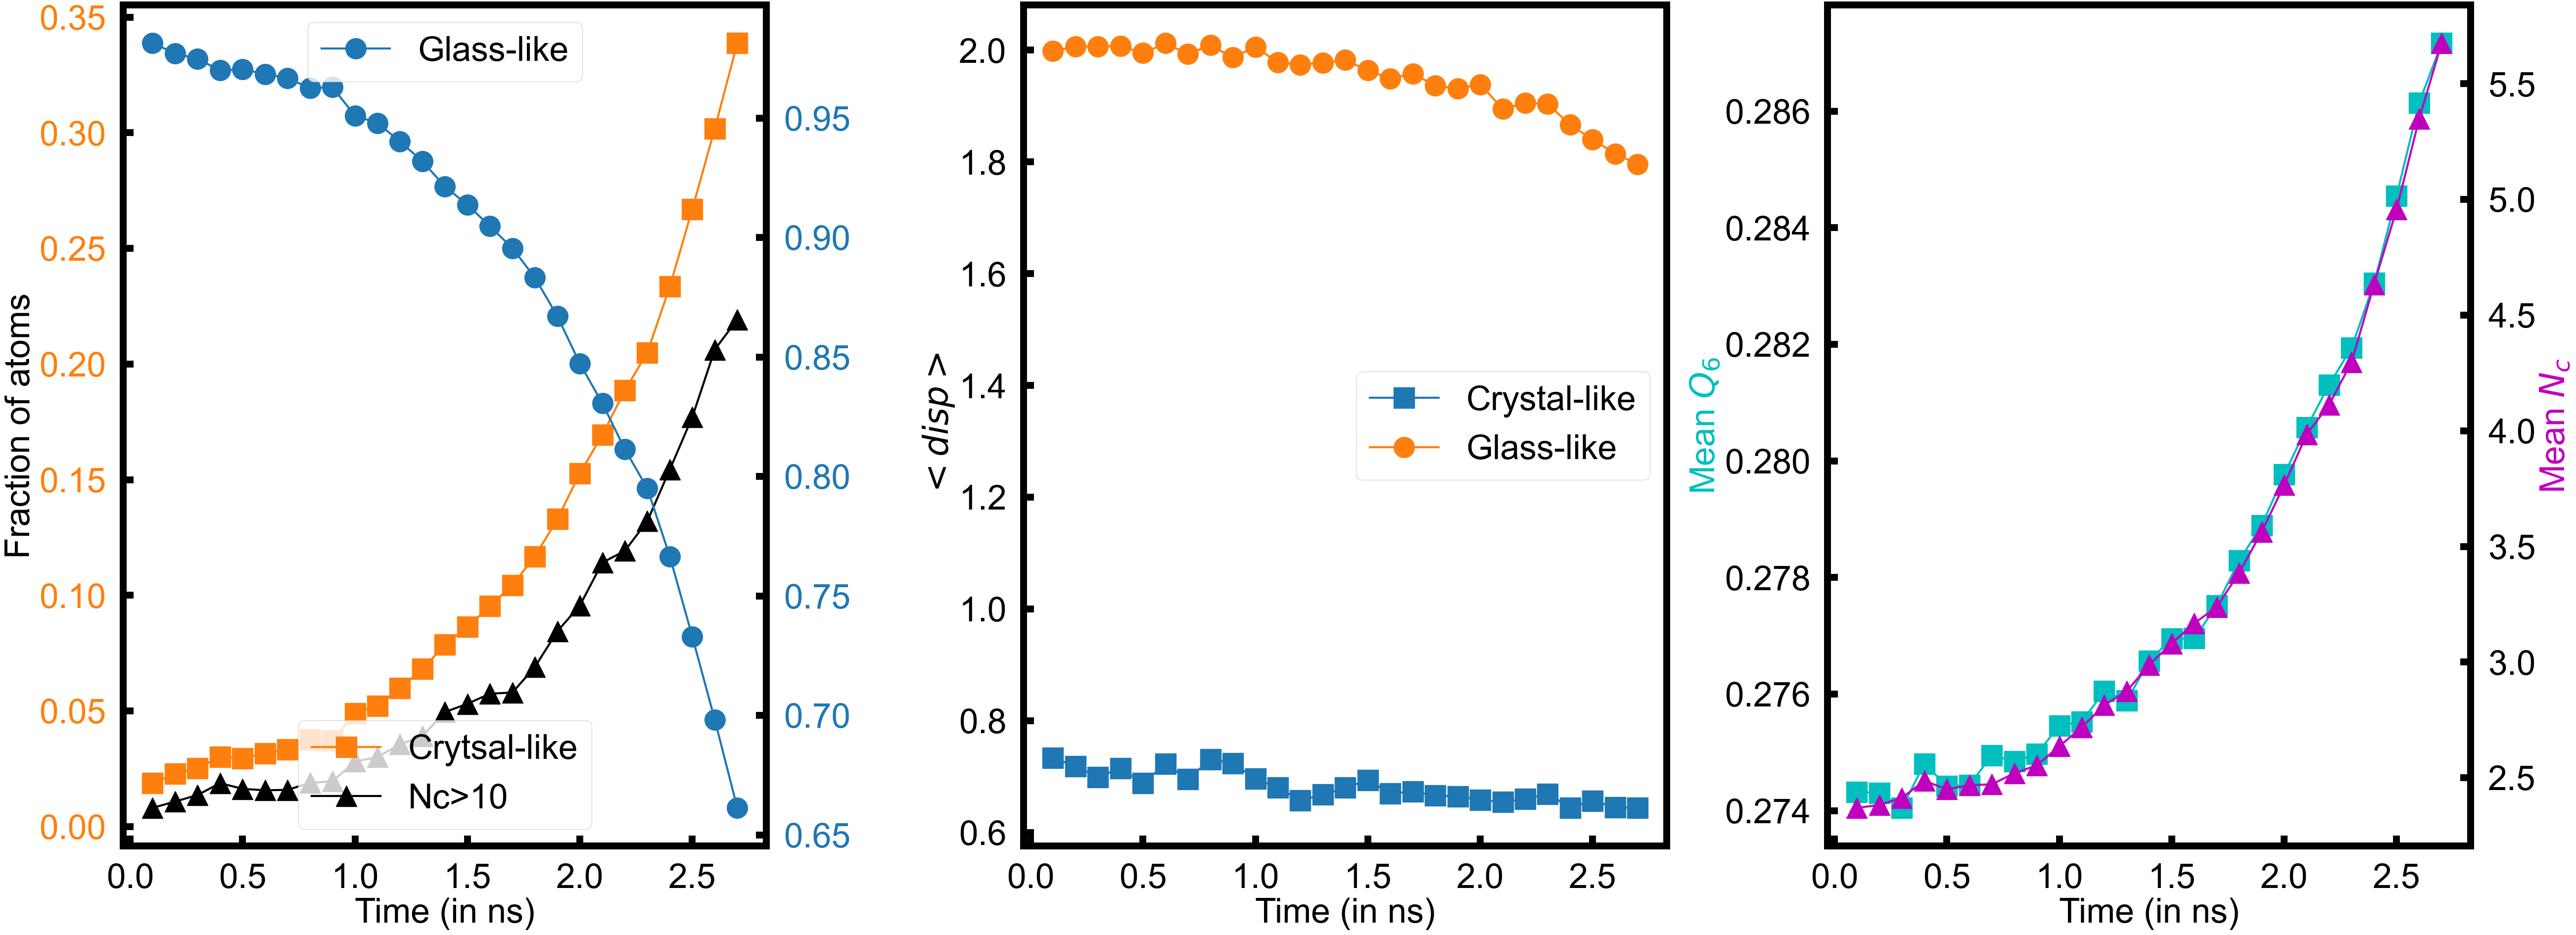

In [13]:
n_atoms_per_cluster = np.asarray(n_atoms_per_cluster)
avg_disp_per_cluster = np.asarray(avg_disp_per_cluster)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 75
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=3.0
plt.rcParams['figure.figsize'] = 65,20
plt.rcParams['lines.markersize']=30.0
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=15
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=15
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'


left,bottom,width,height = 0.04,0.04,0.20,0.85
rect_one = [left, bottom, width, height]
rect_two= [left+width+0.08, bottom, width, height]            
rect_three= [left+2*width+0.13, bottom, width, height]            

one_plot = plt.axes(rect_one)
two_plot = plt.axes(rect_two)
three_plot = plt.axes(rect_three)


time_vals = np.linspace(0.1, 0.1*len(avg_Nc_per_cluster), len(avg_Nc_per_cluster))

one_plot.plot(time_vals,[i/NAT for i in n_atoms_per_cluster[:,0]], marker='s', label='Crytsal-like', color='#ff7f0e')
one_plot.plot(time_vals,[i/NAT for i in ct_Nc_gt_10], marker='^', label='Nc>10', color='k')
one_twin = one_plot.twinx()
one_twin.plot(time_vals,[i/NAT for i in n_atoms_per_cluster[:,1]], marker='o', label='Glass-like', color='#1f77b4')
# one_plot.plot(time_vals,ct_Nc_gt_10, marker='^',lw=0.0, color='red')
one_plot.set_xlabel('Time (in ns)')
one_plot.set_ylabel('Fraction of atoms')

two_plot.plot(time_vals,avg_disp_per_cluster[:,0], marker='s', label='Crystal-like')
two_plot.plot(time_vals,avg_disp_per_cluster[:,1], marker='o', label='Glass-like')
two_plot.set_xlabel('Time (in ns)')
two_plot.set_ylabel('$<disp>$')

three_plot.plot(time_vals,mean_Q6_snap, marker='s', color='c')
three_twin = three_plot.twinx()
three_twin.plot(time_vals,mean_Nc_snap, marker='^', color='m')

three_plot.set_xlabel('Time (in ns)')
three_plot.set_ylabel('Mean $Q_6$', color='c')
three_twin.set_ylabel('Mean $N_c$', color='m')
# three_plot.set_ylim(0.271,0.303)

one_plot.legend(loc='best')
one_twin.legend(loc='upp')
one_twin.yaxis.set_tick_params(labelcolor='#1f77b4')  # Set the color to red
one_plot.yaxis.set_tick_params(labelcolor='#ff7f0e')  # Set the color to red
# one_plot.yticklabels(color='#1f77b4')
two_plot.legend()

# plt.savefig("f_time_evol.pdf",dpi=1500, bbox_inches="tight")
plt.savefig("f_time_evol.png",dpi=500, bbox_inches="tight")
plt.show()

In [10]:
np.savetxt("c_size_evol.txt", n_atoms_per_cluster, delimiter='\t', fmt='%d')